In [1]:
import simpy
import random
import statistics
import pandas as pd
import matplotlib.pyplot as plt

Running simulation... 
The average wait time is 31 minutes and 26 seconds.


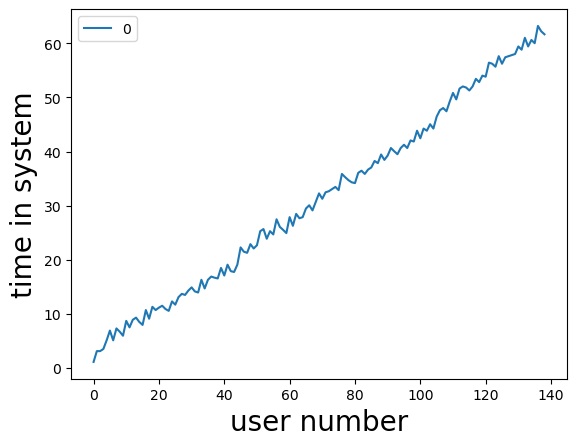

In [2]:
# Adapted from Simpy companion

system_times = []


class Theater(object):
    def __init__(self, env, num_cashiers, num_servers, num_ushers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)
        self.server = simpy.Resource(env, num_servers)
        self.usher = simpy.Resource(env, num_ushers)

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.randint(1, 3))

    def sell_food(self, moviegoer):
        yield self.env.timeout(random.randint(1, 5))

    def check_ticket(self, moviegoer):
        yield self.env.timeout(3 / 60)

    

def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    arrival_time = env.now

    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))

    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))

    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))

    
    # Moviegoer heads into the theater
    system_times.append(env.now - arrival_time)


def run_theater(env, num_cashiers, num_servers, num_ushers):
    theater = Theater(env, num_cashiers, num_servers, num_ushers)

    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))
        #print("movie goer:",moviegoer)

    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new person

        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))
        #print("movie goer:",moviegoer)


def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)


def main():
    # Setup
    random.seed(42)
    num_cashiers = 3
    num_servers = 5 
    num_ushers = 2

    # Run the simulation
    env = simpy.Environment()
    env.process(run_theater(env, num_cashiers, num_servers, num_ushers))
    env.run(until=90)

    # View the results
    mins, secs = get_average_wait_time(system_times)
    print(
        "Running simulation...",
        f"\nThe average wait time is {mins} minutes and {secs} seconds.",
    )

    # Save the results
    df = pd.DataFrame(system_times)
    df.to_csv("system_times.csv")
    
    # Display the results 
    df.plot()
    plt.xlabel('user number', fontsize=20)
    plt.ylabel('time in system', fontsize=20)
    plt.show()


if __name__ == "__main__":
    main()
